In [8]:
#Base Python
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as LogNorm
import ipywidgets
import os


#tools simpeg
import discretize
from SimPEG import electromagnetics
from SimPEG import survey
from SimPEG import utils


#solver
try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

from SimPEG import (
    Data, maps, data_misfit, regularization, optimization, inverse_problem,
    inversion, directives
)
from SimPEG.regularization import sparse

#Modul Magnetotellurik
from SimPEG.electromagnetics import resistivity as dc
from SimPEG.electromagnetics import natural_source as NSEM

##MISC

from discretize import TensorMesh
from SimPEG.utils import mkvc, surface2ind_topo, model_builder
from SimPEG import maps
import numpy as np
import matplotlib.pyplot as plt

## **DEFINE MESH**

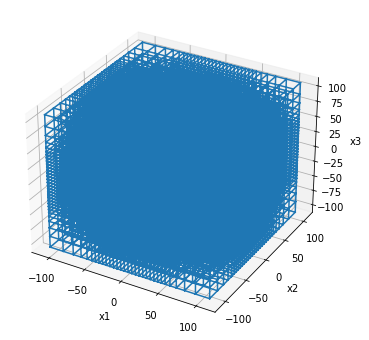

In [2]:
dh = 5.0
hx = [(dh, 5, -1.3), (dh, 20), (dh, 5, 1.3)]
hy = [(dh, 5, -1.3), (dh, 20), (dh, 5, 1.3)]
hz = [(dh, 5, -1.3), (dh, 20), (dh, 5, 1.3)]
mesh = discretize.TensorMesh([hx, hy, hz], "CCC")

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111,projection='3d')
mesh.plotGrid(ax=ax)

plt.show()

In [4]:
print(mesh)


  TensorMesh: 27,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     30       -108.78        108.78      5.00     18.56    1.30
   y     30       -108.78        108.78      5.00     18.56    1.30
   z     30       -108.78        108.78      5.00     18.56    1.30




In [5]:
count = {'numCells':mesh.nC,
         'numCells_xDir':mesh.nCx,
         'numCells_yDir':mesh.nCy,
         'numCells_zDir':mesh.nCz,
         'numCells_vector':mesh.vnC}
print ('This mesh has %(numCells)d cells, which is %(numCells_xDir)d*%(numCells_yDir)d*%(numCells_zDir)d'%(count))

This mesh has 27000 cells, which is 30*30*30


In [6]:
def mesh():

    dh = 5.0
    hx = [(dh, 5, -1.3), (dh, 20), (dh, 5, 1.3)]
    hy = [(dh, 5, -1.3), (dh, 20), (dh, 5, 1.3)]
    hz = [(dh, 5, -1.3), (dh, 20), (dh, 5, 1.3)]
    mesh = TensorMesh([hx, hy, hz], "CCC"),
    x0=["C", "C", -14926.8217]

    return mesh

## **DEFINE MODEL**

In [7]:
M = mesh

# Find cells below topography and define mapping
conds = [1, 1e-5]
ind_block = utils.model_builder.defineBlock(M.gridCC, [-100, -100, -350], [100, 100 -150], conds)
ind_block[M.gridCC[:, 2] > 0] = 1e-8
ind_block[M.gridCC[:, 2] < -100] = 1e-1
ind_blockBG = np.zeros(M.nC) + conds[1]
ind_blockBG[M.gridCC[:, 2] > 0] = 1e-8



# Define a single mapping from model to mesh
exponential_map = maps.ExpMap()
reciprocal_map = maps.ReciprocalMap()
model_map = active_map * reciprocal_map * exponential_map


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
collect_obj = M.plotSlice(np.log10(ind_block), ax=ax, grid=False, normal="X")[0]
color_bar = plt.colorbar(collect_obj)

AttributeError: 'function' object has no attribute 'gridCC'

## **RECEIVER**

In [84]:
# Setup the the survey object
# Receiver locations
rx_x, rx_y = np.meshgrid(np.arange(-600, 601, 100), np.arange(-600, 601, 100))
rx_loc = np.hstack(
    (utils.mkvc(rx_x, 2), utils.mkvc(rx_y, 2), np.zeros((np.prod(rx_x.shape), 1)))
 )

# Make a receiver list
rxList = []
for rx_orientation in ["xx", "xy", "yx", "yy"]:
    rxList.append(NSEM.Rx.Point3DImpedance(rx_loc, rx_orientation, "real"))
    rxList.append(NSEM.Rx.Point3DImpedance(rx_loc, rx_orientation, "imag"))
for rx_orientation in ["zx", "zy"]:
    rxList.append(NSEM.Rx.Point3DTipper(rx_loc, rx_orientation, "real"))
    rxList.append(NSEM.Rx.Point3DTipper(rx_loc, rx_orientation, "imag"))

## **SURVEY**

In [85]:
#Source
scrList = [NSEM.Src.Planewave_xy_1Dprimary(rxList, frequency) for frequency in np.logspace(4, -2, 13)]

#Survey
survey = NSEM.Survey(scrList)

## **PROBLEM**

In [93]:
# Setup the problem object
problem = NSEM.Simulation3DPrimarySecondary(
    M, survey=survey, solver=Solver, sigma=ind_block, sigmaPrimary=ind_blockBG)

In [ ]:
data = NSEM.Data(survey=survey, dobs=problem.dpred())

data.relative_error = 0.1
data.noise_floor = 0.0

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
plt.subplots_adjust(right=0.8)
[(ax.invert_xaxis(), ax.set_xscale("log")) for ax in axes]
ax_r, ax_p = axes
ax_r.set_yscale("log")
ax_r.set_ylabel("Apparent resistivity [xy-yx]")
ax_r_on = ax_r.twinx()
ax_r_on.set_yscale("log")
ax_r_on.set_ylabel("Apparent resistivity [xx-yy]")
ax_p.set_ylabel("Apparent phase")
ax_p.set_xlabel("Frequency [Hz]")
# Start plotting
ax_r = data.plot_app_res(
    np.array([-200, 0]), components=["xy", "yx"], ax=ax_r, errorbars=True
)
ax_r_on = data.plot_app_res(
    np.array([-200, 0]), components=["xx", "yy"], ax=ax_r_on, errorbars=True
)
ax_p = data.plot_app_phs(
    np.array([-200, 0]),
    components=["xx", "xy", "yx", "yy"],
    ax=ax_p,
    errorbars=True,
)
ax_p.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.show()
